<a href="https://colab.research.google.com/github/easoplee/pelvic_project/blob/easop/pelvic_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3D Pelvic Segmentation

In [1]:
new_training = True

In [2]:
#pip install packages

!pip install itk
!pip install itkwidgets
!pip install pydicom
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
class config:
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  LEARNING_RATE = 3e-3
  BATCH_SIZE = 1
  NUM_EPOCHS = 3
  MODEL_PATH = "/content/drive/MyDrive/pelvic_project/output/multi_model.pth"
  PLOT_PATH = "/content/drive/MyDrive/pelvic_project/output/plot.png"

In [6]:
#download the image and ground truth mask
image_dir = '/content/drive/MyDrive/pelvic_project/data/images_3d'
label_dir = '/content/drive/MyDrive/pelvic_project/mask'

#print out the number of images and labels
print(f'Total number of MRI scans: {len(os.listdir(image_dir))}')
print(f'Total number of MRI labels: {len(os.listdir(label_dir))}')

Total number of MRI scans: 23
Total number of MRI labels: 9


In [7]:
DIR_SIZE = len(os.listdir(image_dir))
print(sorted(os.listdir(image_dir)))

['images_01.npy', 'images_02.npy', 'images_03.npy', 'images_04.npy', 'images_05.npy', 'images_06.npy', 'images_07.npy', 'images_08.npy', 'images_09.npy', 'images_10.npy', 'images_11.npy', 'images_12.npy', 'images_13.npy', 'images_14.npy', 'images_15.npy', 'images_16.npy', 'images_17.npy', 'images_18.npy', 'images_19.npy', 'images_20.npy', 'images_21.npy', 'images_22.npy', 'images_23.npy']


In [16]:
#parameters: img_dir -> string that specifies where the images are stored at; label_dir -> similar

def view_img_label(img_dir, label_dir):
  dir_size = DIR_SIZE
  #rand_int = np.random.randint(0, dir_size-1)
  rand_int=0
  ex_img_dir = os.path.join(image_dir, sorted(os.listdir(image_dir))[rand_int])
  ex_img = np.load(ex_img_dir)
  print(ex_img.shape)

  ex_label_dir = os.path.join(label_dir, sorted(os.listdir(label_dir))[rand_int+1])
  print(sorted(os.listdir(label_dir)))
  ex_label = nib.load(ex_label_dir).get_fdata()
  ex_label = np.rot90(ex_label, 1)
  ex_label = cv2.flip(ex_label, 0)
  print(np.unique(ex_label))
  return ex_img, ex_label, ex_img_dir, ex_label_dir

(384, 384, 47)
['.ipynb_checkpoints', 'images_01_mask.nii', 'images_02_mask.nii', 'images_03_mask.nii', 'images_04_mask.nii', 'images_05_mask.nii', 'images_06_mask.nii', 'images_07_mask.nii', 'images_08_mask.nii']
[0. 1. 2. 3. 4. 5.]
image shape: (384, 384, 47)
label shape: (384, 384, 47)


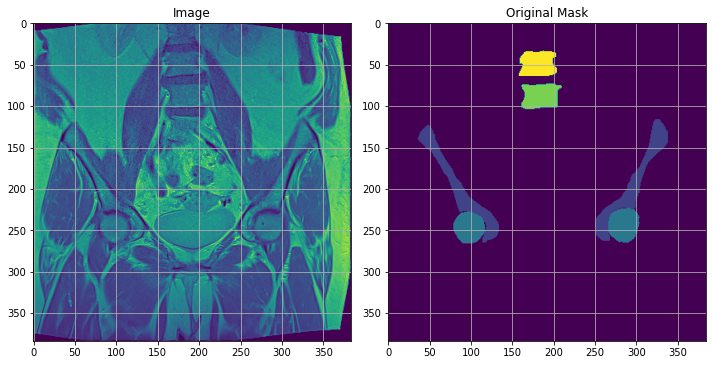

In [17]:
#!pip install matplotlib==3.1.3
ex_img, ex_label, ex_img_dir, ex_label_dir = view_img_label(image_dir, label_dir)
print(f'image shape: {ex_img.shape}')
print(f'label shape: {ex_label.shape}')
#print(ex_img)
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
# plot the original image, its mask, and the predicted mask
ax[0].imshow(ex_img[:,:,25])
ax[1].imshow(ex_label[:,:,25])

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")
ax[0].grid(True)
ax[1].grid(True)

# set the layout of the figure and display it
figure.tight_layout()
figure.show()

In [50]:
class pelvicData(Dataset):
  def __init__(self, path, label_path, fileList):
    #self.files = sorted(os.listdir(path))
    #self.labels = sorted(os.listdir(label_path))
    #self.transform = transform
    self.path = path
    self.labelpath = label_path
    self.fileList = fileList

  def __len__(self):
    return len(self.fileList)

  def __getitem__(self, index):
    filename = os.path.join(self.path, self.fileList[index])

    tensor_image = np.load(filename)
    image = np.zeros((1, tensor_image.shape[0], tensor_image.shape[1], tensor_image.shape[2]))
    image[0, :, :, :] = tensor_image
    tensor_image = torch.Tensor(image/255)
    #tensor_image = torch.permute(tensor_image, (2,0,1))

    label_name = self.fileList[index][:9] + '_mask.nii'
    label_filename = os.path.join(self.labelpath, label_name)
    label = nib.load(label_filename).get_fdata()
    label = np.rot90(label, 1)
    label = cv2.flip(label, 0)
    #mask = np.zeros((1, label.shape[0], label.shape[1], label.shape[2]))
    #mask[0, :, :, :] = label
    #label = resize_img(RGBtoInt(label))
    tensor_label = torch.LongTensor(label)

    return tensor_image, tensor_label

In [51]:
print(image_dir)
print(label_dir)

image_list = sorted(os.listdir(image_dir))[:8]
print(image_list)

valset_length = int(len(image_list) * 0.1) + 1
print(valset_length)

random.shuffle(image_list)

val_list = sorted(image_list[:valset_length])
train_list = sorted(image_list[valset_length:])

print(val_list)
print(train_list)

train_pelvic_dataset = pelvicData(image_dir, label_dir, train_list)
test_pelvic_dataset = pelvicData(image_dir, label_dir, val_list)

/content/drive/MyDrive/pelvic_project/data/images_3d
/content/drive/MyDrive/pelvic_project/mask
['images_01.npy', 'images_02.npy', 'images_03.npy', 'images_04.npy', 'images_05.npy', 'images_06.npy', 'images_07.npy', 'images_08.npy']
1
['images_04.npy']
['images_01.npy', 'images_02.npy', 'images_03.npy', 'images_05.npy', 'images_06.npy', 'images_07.npy', 'images_08.npy']


In [52]:
#plt.imshow(spine_dataset[0][0])

print(np.unique(train_pelvic_dataset[0][1])) #resize with keeping new labels
print(train_pelvic_dataset[0][0].shape)
print(train_pelvic_dataset[0][1].shape)
print(len(train_pelvic_dataset))

print(np.unique(test_pelvic_dataset[0][1])) #resize with keeping new labels
print(test_pelvic_dataset[0][0].shape)
print(test_pelvic_dataset[0][1].shape)
print(len(test_pelvic_dataset))

[0 1 2 3 4 5]
torch.Size([1, 384, 384, 47])
torch.Size([384, 384, 47])
7
[0 1 2 3 4 5]
torch.Size([1, 384, 384, 50])
torch.Size([384, 384, 50])
1


In [53]:
train_dataloader = DataLoader(train_pelvic_dataset, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

train_x, train_y = next(iter(train_dataloader))

print(f'train_x = shape: {train_x.shape}; type: {train_x.dtype}')
print(f'train_x = min: {train_x.min()}; max: {train_x.max()}')
#print(f'train_y = shape: {train_y.shape}; class: {train_y.unique()}; type: {train_y.dtype}')

val_dataloader = DataLoader(test_pelvic_dataset, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

val_x, val_y = next(iter(val_dataloader))
print(f'val_x = shape: {val_x.shape}')
print(f'val_y = shape: {val_y.shape}')

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

print(len(train_dataloader))
print(len(val_dataloader))

train_x = shape: torch.Size([1, 1, 384, 384, 45]); type: torch.float32
train_x = min: 0.0; max: 6.870588302612305
val_x = shape: torch.Size([1, 1, 384, 384, 50])
val_y = shape: torch.Size([1, 384, 384, 50])
7
1


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv_3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv_3d, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        out = self.conv(x)
        return out

class UNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()


        self.enc1 = DoubleConv_3d(1, 16)
        self.enc2 = DoubleConv_3d(16, 32)
        self.enc3 = DoubleConv_3d(32, 64)
        self.enc4 = DoubleConv_3d(64, 128)
        self.enc5 = DoubleConv_3d(128, 128)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        self.dec4 = DoubleConv_3d(256, 64)
        self.dec3 = DoubleConv_3d(128, 32)
        self.dec2 = DoubleConv_3d(64, 16)
        self.dec1 = DoubleConv_3d(32, 16)

        self.conv_final = nn.Conv3d(in_channels=16, out_channels=num_classes, kernel_size=1)

    def forward(self, x):

        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        dec4 = self.dec4(torch.cat((enc4, F.interpolate(enc5, enc4.shape[2:], mode='trilinear')), 1))
        dec3 = self.dec3(torch.cat((enc3, F.interpolate(dec4, enc3.shape[2:], mode='trilinear')), 1))
        dec2 = self.dec2(torch.cat((enc2, F.interpolate(dec3, enc2.shape[2:], mode='trilinear')), 1))
        dec1 = self.dec1(torch.cat((enc1, F.interpolate(dec2, enc1.shape[2:], mode='trilinear')), 1))
        out = self.conv_final(dec1)
        out = torch.sigmoid(out)
        return out


# if __name__ == '__main__':
#     import time
#     import torch
#     from torch.autograd import Variable
#     from torchsummary import summary
#     torch.cuda.set_device(0)
#     net = UNet(num_classes=5).cuda().eval()
#     data = Variable(torch.randn(1, 1, 385, 385, 35)).cuda()
#     start_time = time.time()
#     print("go")
#     summary(net, (1, 385, 385, 47))
#     # for _ in range(500):
#     #     _ = net(data)
#     # print((time.time() - start_time)/500)

In [55]:
#import torchvision
model = UNet(num_classes=6).to(config.DEVICE)
if (not(new_training)): # if training is unnecessary
  #model.load_state_dict(torch.load(config.MODEL_PATH))
  model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model = model.to(config.DEVICE)
#model

In [56]:
if (new_training):
  optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  loss_function = nn.CrossEntropyLoss()

  # calculate steps per epoch for training and test set
  trainSteps = len(train_pelvic_dataset) // config.BATCH_SIZE
  testSteps = len(test_pelvic_dataset) // config.BATCH_SIZE

  # initialize a dictionary to store training history
  H = {"train_loss": [], "test_loss": []}

  print(trainSteps)

7


In [72]:
if (new_training):
  print("[INFO] training the network...")
  startTime = time.time()
  for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
      # send the input to the device
      (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
      # perform a forward pass and calculate the training loss
      print(y.shape)
      pred = model(x)
      #pred = pred['out']
      print(pred.shape)
      loss = loss_function(pred, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
      # set the model in evaluation mode
      model.eval()
      # loop over the validation set
      for (x, y) in val_dataloader:
        # send the input to the device
        (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
        # make the predictions and calculate the validation loss
        pred = model(x)
        totalTestLoss += loss_function(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
  # display the total time needed to perform the training
  endTime = time.time()
  print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([1, 384, 384, 47])
torch.Size([1, 6, 384, 384, 47])
torch.Size([1, 384, 384, 35])
torch.Size([1, 6, 384, 384, 35])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])
torch.Size([1, 384, 384, 41])
torch.Size([1, 6, 384, 384, 41])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])


 33%|███▎      | 1/3 [00:19<00:39, 19.84s/it]

[INFO] EPOCH: 1/3
Train loss: 1.726781, Test loss: 1.7480
torch.Size([1, 384, 384, 41])
torch.Size([1, 6, 384, 384, 41])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])
torch.Size([1, 384, 384, 47])
torch.Size([1, 6, 384, 384, 47])
torch.Size([1, 384, 384, 35])
torch.Size([1, 6, 384, 384, 35])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])


 67%|██████▋   | 2/3 [00:39<00:19, 19.75s/it]

[INFO] EPOCH: 2/3
Train loss: 1.722150, Test loss: 1.7278
torch.Size([1, 384, 384, 41])
torch.Size([1, 6, 384, 384, 41])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])
torch.Size([1, 384, 384, 35])
torch.Size([1, 6, 384, 384, 35])
torch.Size([1, 384, 384, 47])
torch.Size([1, 6, 384, 384, 47])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])
torch.Size([1, 384, 384, 39])
torch.Size([1, 6, 384, 384, 39])
torch.Size([1, 384, 384, 45])
torch.Size([1, 6, 384, 384, 45])


100%|██████████| 3/3 [00:59<00:00, 19.75s/it]

[INFO] EPOCH: 3/3
Train loss: 1.717789, Test loss: 1.7174
[INFO] total time taken to train the model: 59.26s


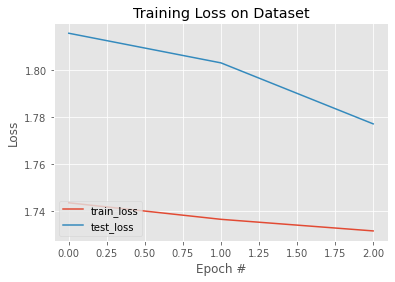

In [59]:
if (new_training):
  # plot the training loss
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H["train_loss"], label="train_loss")
  plt.plot(H["test_loss"], label="test_loss")
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig(config.PLOT_PATH)
  # serialize the model to disk
  torch.save(model, config.MODEL_PATH)

In [60]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

(384, 384, 47)
[0 1 2 3 4 5]


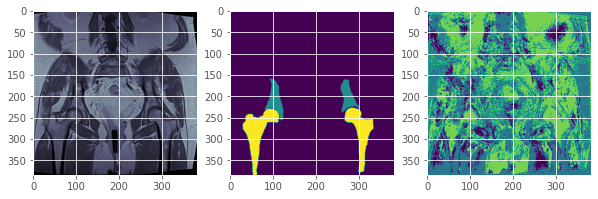

In [76]:
from skimage import io
from skimage import color
from skimage import segmentation

with torch.no_grad():
  model.eval()
  imag = np.load(ex_img_dir)
  imag = imag.astype("float32") / 255.0
  image = np.zeros((1, imag.shape[0], imag.shape[1], imag.shape[2]))
  image[0, :, :, :] = imag
  orig = image.copy()

  gtMask = nib.load(ex_label_dir).get_fdata()
  gtMask = np.rot90(gtMask, 1)
  gtMask = cv2.flip(gtMask, 0)
  print(gtMask.shape)
  gt_Mask_t = torch.tensor(gtMask)

  image = np.expand_dims(image, 0)
  image = torch.Tensor(image).to(config.DEVICE)
  predMask = model(image)
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()

  #y_true, y_pred = onehot(gtMask, predMask)
  #dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
  #print(f'For original mask and predicted mask {dice_score}')

  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
  ax[0].imshow(orig[0,:,:,30], cmap=plt.cm.bone)
  ax[1].imshow(gtMask[:,:,30])
  ax[2].imshow(predMask[:,:,30])
  print(np.unique(predMask[:,:,30]))